In [1]:
import jax
from jax import numpy as jnp
from jax import lax
from jax import jit

jax.config.update("jax_enable_x64", True)

import sys

sys.path.append("../lib/")
import matplotlib.pyplot as plt
from figparams import *

plt.rcParams.update(rc_params)
from utils import *


from astropy.cosmology import Planck18
import astropy.constants as const

# Constants
Planck18_H0 = Planck18.H0.si.value
H02 = Planck18_H0**2
clight = 299792458.0  # Speed of light in m/s
L = 8.3  # Arm length of LISA in seconds
year = 31557600.0  # Seconds in a year
msun = const.M_sun.si.value
c = const.c.value
G = const.G.value
Mpc = const.pc.value * 1e6

import average_envelope as env

import numpy as np
import bahamas.psd_strain.psd_function as psd
import bahamas.psd_response.response as resp


# Create a figure and two horizontal subplots
from matplotlib.patches import FancyArrowPatch
from math import radians, cos, sin
from matplotlib.gridspec import GridSpec
from matplotlib.cm import get_cmap

# color gradient of blue
from matplotlib.colors import LinearSegmentedColormap

2025-11-02 20:59:45,591 - BAHAMAS - INFO - Using JAX backend.
2025-11-02 20:59:45,592 - BAHAMAS - INFO - np is from: jax.numpy


<module 'jax.lax' from '/home/riccardo/Software/anaconda3/envs/bahamasgf/lib/python3.13/site-packages/jax/lax/__init__.py'>


In [2]:
day = 86400
chunk = 15 * day
Ttot = 24 * chunk
colors_tot = get_colormap_colors(24, "plasma")
colors = colors_tot[:12][::-1]

year = 31557600.0

# Galaxy Parameters Modulation
Lat = -0.09664565
Long = -1.6259238
s1 = 0.04156049812924856
s2 = 0.13842963137295858
psi = -0.9900146151015816
Lomega = 1 / year


# Galaxy Paramters Spectrum
alpha = 1.80
# amp1 = -45.24
amp = -43.894309514866350
a1 = -0.25
ak = -0.27
b1 = -2.70
bk = -2.47
# logf1 = -2.856
logf2 = -3.487854923626168
# fkn1 = -3.2
# fkn2 = -2.595679532778269

# time segments
T = np.arange(0, Ttot + chunk, chunk)
t1 = T[:-1]
t2 = T[1:]
tmed = (t2 + t1) / 2
Amp_mod = env.average_envelopes_gaussian(
    Lat, Long, s1, s2, psi, LISA_Orbital_Freq=1 / year, t1=t1, t2=t2, alpha0=0, beta0=0
)

freqs = np.linspace(1e-4, 0.029, 1000)
noise_params = {"A": 2.4, "P": 7.9, "Tobs": year}
noise = psd.noise(freqs, noise_params, tdi=0, gen2=False)
EF_params = {"a": -10.76, "gamma1": 0.741, "gamma2": -0.255}
ef_signal = psd.Omega_extra_foreground(freqs, EF_params)
matr = resp.get_response(freqs, gen2=False, equal_arm=True, cross_term=False, tdi="AET")
psd_ef = matr[0] * ef_signal


ind = [0, 3, 5, 10, 14, 17, 22]


def truncate_colormap(cmap_name="Blues", minval=0.3, maxval=1.0, n=100):
    base_cmap = plt.get_cmap(cmap_name)
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap_name},{minval:.2f},{maxval:.2f})",
        base_cmap(np.linspace(minval, maxval, n)),
    )
    return new_cmap

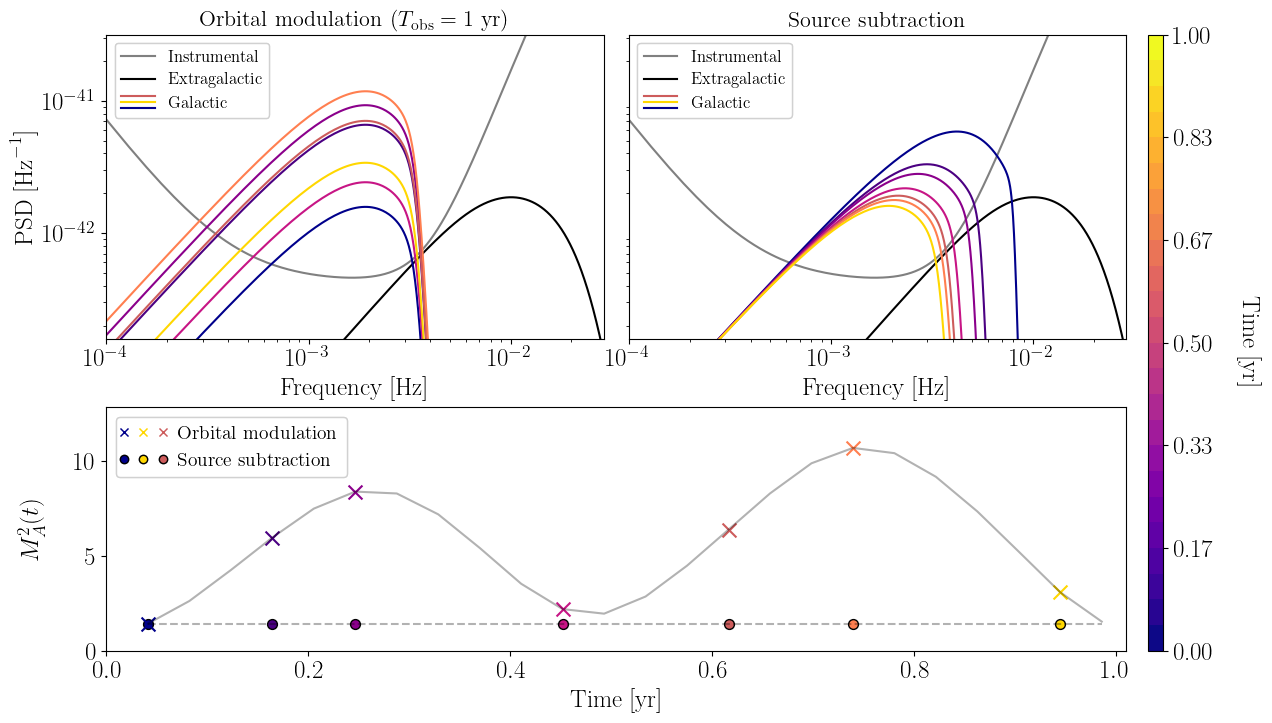

In [3]:
curve = []
for i in range(len(ind)):
    amp_spec = galaxy_spectrum(
        alpha, amp, a1, ak, b1, bk, logf2, Tobs=t2[-1] / year, f=freqs
    )
    spec = Amp_mod[ind[i]] * amp_spec
    curve.append(spec)
curve = np.array(curve)

curve2 = []
for i in range(len(ind)):
    amp_spec = galaxy_spectrum(
        alpha, amp, a1, ak, b1, bk, logf2, Tobs=t2[ind[i]] / year, f=freqs
    )
    spec = Amp_mod[0] * amp_spec
    curve2.append(spec)
curve2 = np.array(curve2)
# Plot the galaxy spectrum for each time segment


fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 2, height_ratios=[1, 0.8])
ax0 = fig.add_subplot(gs[0, 0])  # Top-left
ax1 = fig.add_subplot(gs[0, 1])  # Top-right
ax2 = fig.add_subplot(gs[1, :])  # Bottom full-width

# Share y axis between ax0 and ax1

ax2.plot(t2 / year, Amp_mod, color="k", alpha=0.3)
ax2.plot(
    t2 / year, np.ones_like(t2) * Amp_mod[ind[0]], color="k", alpha=0.3, linestyle="--"
)
for i in range(len(ind)):
    ax2.scatter(
        t2[ind[i]] / year,
        Amp_mod[ind[0]],
        s=50,
        marker="o",
        color=colors_tot[ind[i]],
        edgecolors="k",
    )
    ax2.scatter(
        t2[ind[i]] / year,
        Amp_mod[ind[i]],
        s=100,
        marker="x",
        color=colors_tot[ind[i]],
    )

ax2.set_xlabel("Time [yr]")
ax2.set_ylabel("$M^2_A (t)$")
ax2.set_ylim(0, 1.2 * np.max(Amp_mod))
ax2.set_xlim(0, 1.01)

ax0.loglog(freqs, noise, color="gray", alpha=1.0)
ax1.loglog(freqs, noise, color="gray", alpha=1.0)
ax0.loglog(freqs, psd_ef, color="k", alpha=1)
ax1.loglog(freqs, psd_ef, color="k", alpha=1)

for i in range(len(ind)):
    ax0.loglog(
        freqs,
        curve[i],
        color=colors_tot[ind[i]],
        label=f"{t2[ind[i]] / chunk:.1f} week",
    )
ax0.set_ylim(10**-42.8, 10**-40.5)
ax0.set_xlim(10**-4.0, 0.029)


for i in range(len(ind)):
    ax1.loglog(
        freqs,
        curve2[i],
        color=colors_tot[ind[i]],
        label=f"{t2[ind[i]] / chunk:.1f} week",
    )
# Make ax1 y-axis shared with ax0

ax1.set_ylim(10**-42.8, 10**-40.5)
ax1.set_xlim(10**-4.0, 0.029)

ax0.set_xlabel("Frequency [Hz]")
ax1.set_xlabel("Frequency [Hz]")
ax0.set_ylabel("PSD $[\mathrm{Hz}^{-1}]$")
ax1.set_yticks([])

# ax1.set_ylabel('PSD $[\mathrm{Hz}^{-1}]$')

ax1.set_title(r"Source subtraction", fontsize=16)
ax0.set_title(r"Orbital modulation ($T_{\mathrm{obs}} = 1$ yr)", fontsize=16)


# fixing pad between subplots
plt.subplots_adjust(hspace=0.25, wspace=0.05)


noise_line = mlines.Line2D([], [], color="gray", linestyle="solid")
ef_line = mlines.Line2D([], [], color="black", linestyle="solid")
gf_line = mlines.Line2D([], [], color=colors_tot[ind[2]], linestyle="solid")
handles = [noise_line, ef_line, gf_line]
labels = ["Instrumental", "Extragalactic", "Galactic"]

# --- Colors for the stacked Galactic lines ---
galactic_colors = [colors_tot[ind[0]], colors_tot[ind[-1]], colors_tot[ind[4]]]

legen = ax0.legend(
    handles,
    labels,
    fontsize=12,
    loc="upper left",
    handler_map={gf_line: HandlerThreeLines(galactic_colors, spacing=0.5)},
)
ax0.add_artist(legen)

legen = ax1.legend(
    handles,
    labels,
    fontsize=12,
    loc="upper left",
    handler_map={gf_line: HandlerThreeLines(galactic_colors, spacing=0.5)},
)
ax1.add_artist(legen)

crosses_line = mlines.Line2D([], [], color="gray", linestyle="solid")
circles_line = mlines.Line2D([], [], color="black", linestyle="solid")

# add colorbar at figure on right and side using colors_tot
cmap = plt.get_cmap("plasma", 24)
norm = plt.Normalize(vmin=0, vmax=24)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for older Matplotlib versions
cbar = fig.colorbar(
    sm, ax=[ax0, ax1, ax2], orientation="vertical", fraction=0.04, pad=0.02, aspect=40
)
cbar.set_ticks(np.arange(0, 28, step=4))
cbar.set_ticklabels([f"{i:.2f}" for i in np.linspace(0, 1, 7)])
cbar.set_label("Time [yr]", rotation=270, labelpad=35)

fig.set_constrained_layout_pads(w_pad=0.5, h_pad=0.5, hspace=0.2, wspace=0.2)
# Move ax2 ylabel a bit to the left
ax2.yaxis.set_label_coords(-0.06, 0.5)

handles = [crosses_line, circles_line]
labels = ["Orbital modulation", " Source subtraction"]

legen = ax2.legend(
    handles,
    labels,
    fontsize=14,
    loc="upper left",
    handler_map={
        crosses_line: HandlerThreeMarkers(
            galactic_colors, spacing=0.5, marker="x", markersize=6
        ),
        circles_line: HandlerThreeMarkers(
            galactic_colors, spacing=0.5, marker="o", markersize=6, markeredgecolor="k"
        ),
    },
)
ax2.add_artist(legen)
fig.savefig(f"../plots/Figure1.pdf", bbox_inches="tight", dpi=300)
